<a href="https://colab.research.google.com/github/Ha-eunYu/pix2pix/blob/main/pix2pix_230209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory
import torch

# colab-GPU 사용 확인
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('GPU 연결 실패!')
else:
  print(gpu_info)

# RAM 사용량 체크
ram_gb = virtual_memory().total / 1e9
print('{:.1f} gigabytes of available RAM\n'.format(ram_gb))

# pytorch-GPU 연결 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('학습을 진행하는 기기:',device)

# 구글 드라이브 연결. 만약 직접 데이터셋을 사용한다면 주석 해제.
# from google.colab import drive
# drive.mount('/content/drive')

Sun Feb 12 16:54:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#  동적 코드 다운
!pip install fastai==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 17.7 MB/s eta 0:00:00
     ━━━━━━

In [3]:
from fastai.data.external import untar_data,URLs
import glob

coco_path = untar_data(URLs.COCO_SAMPLE)

In [4]:
print(coco_path)

/root/.fastai/data/coco_sample


In [5]:
paths = glob.glob(str(coco_path) + "/train_sample/*.jpg")

In [6]:
import numpy as np

np.random.seed(1)
chosen_paths = np.random.choice(paths, 5000, replace=False)
index = np.random.permutation(5000)

train_paths = chosen_paths[index[:4000]] # 앞의 4000을 train 이미지 쓰겠다.
val_paths = chosen_paths[index[4000:]]

print(len(train_paths))
print(len(val_paths))

4000
1000


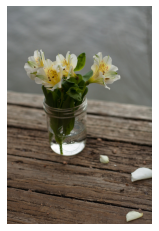

In [7]:
import matplotlib
import matplotlib.pyplot as plt

sample = matplotlib.image.imread(train_paths[2])
plt.imshow(sample)
plt.axis("off")
plt.show()

In [8]:
# 기본적인 데이터 로더
import torch
from torch.utils.data import Dataset

In [9]:
x = np.random.randint(0, 100, 5)
y = np.random.randint(0, 100, 5)
print(x)
print(y)

[13 76 68 69  3]
[32 20 70 22 97]


In [10]:
x = torch.Tensor(x)
y = torch.Tensor(y)
print(x)
print(y)

tensor([13., 76., 68., 69.,  3.])
tensor([32., 20., 70., 22., 97.])


In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import ImageDraw
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [19]:
# tensor 데이터를 순차적으로 받기 위해서 이미지를 tesor로 만듬
# Dataset를 상속: Dataset기능을 사용
class ColorizationDataset(Dataset):
  def __init__(self, paths, mode='train'):
      self.mode = mode
      self.paths = paths

      if mode == "train":
        # 데이터 전처리, MSCOCO는 이미지 사이즈 다름
        # init 안에 transforms.Compose만듬, 함수만드는 느낌으로
        # 면접에서 말하는 전처리: resize, Data augmentation(RondomHorizontalFlip)
        self.transforms = transforms.Compose([
            transforms.Resize((256,256), Image.BICUBIC),
            # data augmentation이 많이 하면 점수가 올라가기도 함 하지만 
            # 논문에서 작년에 제일 잘한 모델 augmentation사용
            # 왜냐면 모델이 무거워짐
            transforms.RandomHorizontalFlip()
        ])
      elif mode == "val":
        self.transforms = transforms.Resize((256,256), Image.BICUBIC)
      else:
        raise Exception("train or validation only!!!!")
  
  # 매 iteration 마다 이미지를 인덱스에 맞춰서 꺼내줌
  def __getitem__(self, index):
      # .convert("RGB") 안붙이면 gray channer이 들어와서 오류 
      # gray채널은 rgb로
      img = Image.open(self.paths[index]).convert("RGB")
      img = np.array(self.transforms(img))
      img = rgb2lab(img).astype("float32") # RGE 채널을 Lab채널로 변환해 주는 것! YCBCR을 많이 사용
      # tensor로 변환
      img = transforms.ToTensor()(img)
      L = img[[0], ...] /50. -1 # -1 ~ 1 사이로 정규화 진행
      ab = img[[1,2], ...] /110. # -1 ~ 1 사이로 정규화 진행

      # 딕션너리로 리턴
      return {'L':L, 'ab' : ab}

  def __len__(self):
      return len(self.paths)

In [13]:
ColorizationDataset

__main__.ColorizationDataset

In [14]:
dataset_train = ColorizationDataset(train_paths, mode ='train')
dataset_val = ColorizationDataset(val_paths,mode='val')

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [15]:
# dataLoader에 class를 인자로(get item이 있으니까 tensor 넣는 것과 같음)
dataloader_train = DataLoader(dataset_train, batch_size=16, num_workers=2, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=16, num_workers=2, pin_memory=True)

In [21]:
import torch.nn as nn

# 비선형 변환 한번 선형변환 한번해서 현실세계의 복잡한 것을 근사
# nn.Module상속
# skip connection편하게 하기 위해서 나눠서 함
class pix2pix_Generator(nn.Module):
  def __init__(self):
    super(pix2pix_Generator, self).__init__()

    self.input_layer = nn.Sequential(
        # 너비와 높이가 2배씩 증가
        # input_channels: L channel 
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    ) # L channels [1*256*256] -> [64*128*128]

    # DC GAN
    self.encoder_1 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True), # [128*64*64]
        nn.BatchNorm2d(128)
    )

    self.encoder_2 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True), # [256*32*32]
        nn.BatchNorm2d(256)
    )

    self.encoder_3 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=True), # [512*16*16]
        nn.BatchNorm2d(512)
    )

    self.encoder_4 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True),# [512*8*8]
        nn.BatchNorm2d(512)
    )

    self.encoder_5 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True), # [512*4*4]
        nn.BatchNorm2d(512)
    )

    self.encoder_6 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True), # [512*2*2]
        nn.BatchNorm2d(512)
    )

    self.middle = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False), # [512*1*1]
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False), # [512*2*2]
        nn.BatchNorm2d(512)
    )

    self.decoder_6 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False), # [(512+512)*2*2] -> [512*4*4]
        nn.BatchNorm2d(512),
        nn.Dropout(0.5)
    )

    self.decoder_5 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False), # [(512+512)*4*4] -> [512*8*8]
        nn.BatchNorm2d(512),
        nn.Dropout(0.5)
    )

    self.decoder_4 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False), # [(512+512)*8*8] -> [512*16*16]
        nn.BatchNorm2d(512),
        nn.Dropout(0.5)
    )

    self.decoder_3 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1, bias=False), # [(512+512)*16*16] -> [256*32*32] 
        nn.BatchNorm2d(256),
        nn.Dropout(0.5)
    )

    self.decoder_2 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1, bias=False), # [(256+256)*32*32] -> [128*64*64]
        nn.BatchNorm2d(128),
        nn.Dropout(0.5)
    )

    self.decoder_1 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False), # [(128+128)*64*64] -> [64*128*128]
        nn.BatchNorm2d(64),
        nn.Dropout(0.5)
    )

    # output_channel: a channel, b channel
    self.output_layer = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )
    


  def forward(self, x):
    input_layer = self.input_layer(x)
    
    encoder_1 = self.encoder_1(input_layer)
    encoder_2 = self.encoder_2(encoder_1)
    encoder_3 = self.encoder_3(encoder_2)
    encoder_4 = self.encoder_4(encoder_3)
    encoder_5 = self.encoder_5(encoder_4)
    encoder_6 = self.encoder_6(encoder_5)
    
    middle = self.middle(encoder_6)

    # skip connection: HF 디테일이 사라지는 것을 방지
    cat_6 = torch.cat((middle, encoder_6), dim=1)
    decoder_6 = self.decoder_6(cat_6)
    cat_5 = torch.cat((decoder_6, encoder_5), dim=1)
    decoder_5 = self.decoder_5(cat_5)
    cat_4 = torch.cat((decoder_5, encoder_4), dim=1)
    decoder_4 = self.decoder_4(cat_4)
    cat_3 = torch.cat((decoder_4, encoder_3), dim=1)
    decoder_3 = self.decoder_3(cat_3)
    cat_2 = torch.cat((decoder_3,encoder_2), dim=1)
    decoder_2 = self.decoder_2(cat_2)
    cat_1 = torch.cat((decoder_2, encoder_1), dim=1)
    decoder_1 = self.decoder_1(cat_1)

    output = self.output_layer(decoder_1)

    return output

In [22]:
pix2pix_Generator()

pix2pix_Generator(
  (input_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (encoder_1): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_2): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_3): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_4): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(512, 512, kern

In [ ]:
# 이미지들간의 관계, 분포를 파악, 선형변환 한번, 비선형변환 한번
class pix2pix_Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Suquential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, True),

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, True),

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, True),

        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, True),

        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1. bias=False)
    )

    def forward(self, x):
      return self.model(x)




In [17]:
# class Discriminator(nn.Module):
#   def __init__(self):    
#     super(Discriminator, self).__init__()

#     # C64 : [(2+1)x256x256] -> [64x128x128]
#     self.conv1 = nn.Sequential(
#         nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.LeakyReLU(0.2, True)
#         )
#     # C128 : -> [128x64x64]
#     self.conv2 = nn.Sequential(
#         nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#         nn.BatchNorm2d(128),
#         nn.LeakyReLU(0.2, True)
#         )
#     # C256 -> [256x32x32]
#     self.conv3 = nn.Sequential(
#         nn.Conv2d(128,256,4,2,1),
#         nn.BatchNorm2d(256),
#         nn.LeakyReLU(0.2, True)
#         )
#     # C512 -> [512x31x31]
#     self.conv4 = nn.Sequential(
#         nn.Conv2d(256,512,4,1,1),
#         nn.BatchNorm2d(512),
#         nn.LeakyReLU(0.2, True)
#         )
#     # C512 -> [1x30x30]
#     self.conv5 = nn.Sequential(
#         nn.Conv2d(512,1,4,1,1),
#         # nn.BatchNorm2d(256),
#         nn.Sigmoid()
#         )
        
#   # ab: 실제/변환된 이미지 a & b chanel, L: 조건(condition) L_channel
#   def forward(self,ab,L):
#     out = torch.cat((L,ab), dim=1)
#     out = self.conv1(out)
#     out = self.conv2(out)
#     out = self.conv3(out)
#     out = self.conv4(out)
#     out = self.conv5(out)

#     return out        

In [23]:
# local minimum을 피하고 globalminimum에 다다르기 위해서
def init_weights(m):
  # layer가 컨볼류션이라면!
  if type(m) == nn.Conv2d:
    nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    print("Conv2d Initialized!!!!!!!")
  # layer가 전치컨볼루션이라면!
  elif type(m) == nn.ConvTranspose2d:
    nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    print("Transposed Convolution Initialized!!!!!!!")
  elif type(m) == nn.BatchNorm2d:
    nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
    nn.init.constant_(m.bias.data, 0.)
    print("BatchNorm2d Initialized!!!")

def model_initialize(model):
  model.apply(init_weights)
  return model
    

In [24]:
class GANLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.register_buffer("real_label", torch.tensor(1.0))
    self.register_buffer("fake_label", torch.tensor(0,0))
    self.loss == nn.BCWighLongitsLoss()

  def get_labels(self, preds, target_is_real):
    if target_is_real:
      labels = self.real_label
    else:
      label = self.fake_label
    return label.expand_as(preds)

  def __call__(self, preds, target_is_real):
    labels = self.get_labels(preds, target_is_real)
    loss = self.loss(preds, labels)
    return loss

In [25]:
def lab_to_rgb(L, ab):
  # 정규화를 반대로 합니다.
  L = (L + 1) * 50.
  ab = ab * 110
  # Lab 컬러 채널을 합쳐야 합니다.
  # [배치 사이즈, 채널, 256, 256] -> [배치 사이즈, 256, 256, 채널]
  Lab = torch.cat([L, ab], dim = 1).permute(0, 2, 3, 1).cpu().numpy()
  # 이미지를 저장할 리스트를 선언
  rgb_image = []

  for img in Lab:
    img_rgb = lab2rgb(img)
    rgb_image.append(img_rgb)
  return np.stack(rgb_image, axis=0)


In [27]:
from torch import optim

In [26]:
# generator을 선언하고 초기화 해 준다!
# class의 intstance
# generator를 선언하고 초기화한다.
model_generator = init_weights(pix2pix_Generator())
# generator를 gpu로 보내준다: .to(device)
model_generator.to(device)

# discrminator를 선언하고 초기화한다.
model_discriminator = init_weights(pix2pix_Discriminator())
# discrminator를 gpu로 보내준다.
model_discriminator.to(device)

# 로스 함수 선언
criterion = GANLoss().to(device)
# L1 로스 함수 함수 선언한다.
L1 = nn.L1Loss()

# optimizer를 선언!!!!
# 최적화하는 방법 설정
# 무엇의 파라미터를 최적화하는지
optimizer_generator = optim.Adam(model_generator.parameters(), lr=2e-4, beats=(0.5, 0.999))
optimizer_discriminator = optim.Adam(model_discriminator.parameters(), lr=2e-4, beats=(0.5, 0.999))

# 하이퍼파라미터
epoch = 1000

# epoch 돕시다
for e in range(epoch):
  # tqdm을 선언합니다.
  # data 형태 : dic
  for index, data in enumerate(tqdm(dataloader_train)):
    # 데이터를 가져와서 gpu로 보내자
    # L 데이터를 받아옵시다.
    L = data['L'].to(device)
    # real color
    ab = data['ab'].to(device)
    
    # 가짜 색 생성해보자
    # Generator가 만든 fake color
    fake_color = model_generator(L)
    
    # -------------------------------------------------- 훈련준비 --------------------------------------------------
    # Discriminator를 훈련 시작한다.
    model_discriminator.train()
    '''
    하나의 for문에서 G와 D가 동시에 학습 불가, D가 훈련시에는 G가 멈춰야 함
    D는 시작함
    '''
    # D의 멈춰진 훈련을 재개한다. -> Freezing
    for parameter in model_discriminator.parameters():
      # D의 모든 파라미터에 기울기를 저장하겠다. -> 역전파를 하겠다.
      parameter.requires_grad = True
    
    '''
    기울기 초기화, pytorch에서는 iteration이 끝나면 gradient값을 항상 0으로 
    이전 iteration에서의 기울기 값이 현재 iteration에 영향을 끼칠 수 있기 때문 
    모든 파라미터 마다 어느 값으로 이동하지 정해짐
    0.34만큼 움직여 -> 다음 iteration: + 0.33 >> 누적되어 움직임
    interation끼리 연결 안되도록
    '''
    optimizer_discriminator.zero_grad()

    # -------------------------------------------------- 훈련준비 --------------------------------------------------
    
    # 가짜 이미지를 만들고 discriminator에 가짜라고 알려주면서 넣어주자!!
    # Discriminator가 3채널 인풋으로 받고 있으니, Lab채널을 torch.cat해줌
    fake_image = torch.cat([L, fake_color], dim=1)
    '''
    Discriminator가 학습하는데, Generator가 혹시라도 영향을 받을까봐 .datach() 역전파를 막는다.
    D만 학습, G가 만든 이미지이니까, 역전파 G는 영향받지 않도록
    copy는 연전파 까지 복사
    '''
    fake_preds = model_discriminator(fake_image.detach())
    '''
    Discriminator가 업데이트되기 위해서 Loss함수를 계산
    여기에서 중요한 메인 포인트는 "Discrminator"가 학습해야하니 정답지를 알려줘야함
    False를 던져준 이유는 이게 가짜 이미지다"를 알려주는 것
    '''
    loss_discriminator_fake = criterion(fake_preds, False)

    # 진짜 이미지를 만들고 Discriminator에 가짜라고 알려주면서 넣어주자!!(학습)
    real_image = torch.cat([L, ab], dim=1)
    # 진짜 이미지를 Discriminator에 넣고, Discriminator의 로스를 계산
    real_preds = model_discriminator(real_image)
    loss_discriminator_real = criterion(real_preds, True)

    # Discriminator의 두 가지 로스를 더해서 역전파 시킬 수 있게 만들어 주자!!
    loss_discriminator_total = (loss_discriminator_fake + loss_discriminator_real) * 0.5

    loss_discriminator_total.backward()
    optimizer_discriminator.step()





    # # G가 훈련이 시작된 상태!
    # # D는 훈련이 멈춘 상태!
    # for parameter in model_discriminator.parameters():
    #   # D의 모든 파라미터에 기울기를 저장하겠다. -> 역전파를 하겠다.
    #   parameter.requires_grad = True






AttributeError: ignored

In [ ]:
?